# Optimization using or tools

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

### Import OR tools

In [4]:
from ortools.sat.python import cp_model
from ortools.linear_solver import pywraplp

### Loading the data 

In [5]:
df = pd.read_excel('data_optim.xls')
price = df.Prix.tolist()

## Formulation of optim problem

**$ max \sum_{h \in heures} Prix(h)\times(-Edecharge(h)-Echarge(h))$**

[1]$0 \leq Echarge(h) \leq Pmax $        

[2] $ -Pmax \leq Edecharge(h) \leq 0 $     

[3] $ SoC(h+1) = SoC(h) + \rho Edecharge(h)+Echarge(h) $      

[4] $0 \leq SoC(h) \leq Emax $                      

[5] $ SoC(0) = 0$                                 

## Solving

In [43]:
def optim(price,rho=0.9,Pmax=1,Emax=1):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    nhours = len(price)
    # Create variables
    # Echarge[i] is an array of 0-Pmax continous
    Echarge = {}
    for i in range(nhours):
        Echarge[i] = solver.NumVar(0, Pmax, '')
    Edecharge = {}
    for i in range(nhours):
        Edecharge[i] = solver.NumVar(-Pmax,0,'')
    SoC ={}
    for i in range(nhours):
        SoC[i]  = solver.NumVar(0,Emax,'')
    # Add constraints
    # Initialization constraints
    solver.Add(SoC[0]==0)
    # State of Charge constraint
    for h in range(nhours-1):
        solver.Add(SoC[h+1] == SoC[h]+rho*Echarge[h]+Edecharge[h] )
    # Create objective
    objective_terms = []
    for h in range(nhours):
        objective_terms.append(-price[h] * (Echarge[h]+Edecharge[h]))
    # Solve problem
    solver.Maximize(solver.Sum(objective_terms))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print(f'Solution - rho = {rho} || Pmax ={Pmax} || Emax ={Emax}\n')
        print('Objectif = ', solver.Objective().Value(), '\n')
        sol_charge  =[]
        sol_decharge = []
        sol_SoC = []
        for h in range(nhours):
            # Save solution
            sol_charge.append(Echarge[h].solution_value())
            sol_decharge.append(Edecharge[h].solution_value())
            sol_SoC.append(SoC[h].solution_value())
        # Display charge & discharge
    plt.figure(figsize=(25,8))
    plt.subplot(1,2,1)
    plt.plot(sol_charge,label='Charge')
    plt.xlabel('Heures')
    plt.ylabel('[MW]')
    plt.plot(sol_decharge,label='Decharge')
    plt.legend()
    plt.title('Cycle de charge & de decharge')
    # Display State of Charge
    plt.subplot(1,2,2)
    plt.plot(sol_SoC,c="g",label="State of Charge")
    plt.xlabel('Heures')
    plt.ylabel('SoC')
    plt.title('Evolution de SoC')
    plt.legend()
    plt.show()
    # Profits 
    profit = []
    for h in range(nhours):
        p = price[h]*(sol_charge[h]+sol_decharge[h])*-1
        profit.append(p)
    plt.figure(figsize=(8,6))
    plt.xlabel('Heures')
    plt.ylabel('Profit (€)')
    plt.plot(profit,label='Profit journalier')
    plt.plot(np.cumsum(profit),label="Profit cumulé")
    plt.title(f"Evolution du profit ({round(sum(profit),2)}€) - rho = {rho}")
    plt.legend()
    plt.show()
    return(profit)

Solution - rho = 0.81 || Pmax =1 || Emax =1

Objectif =  610.6251975308643 



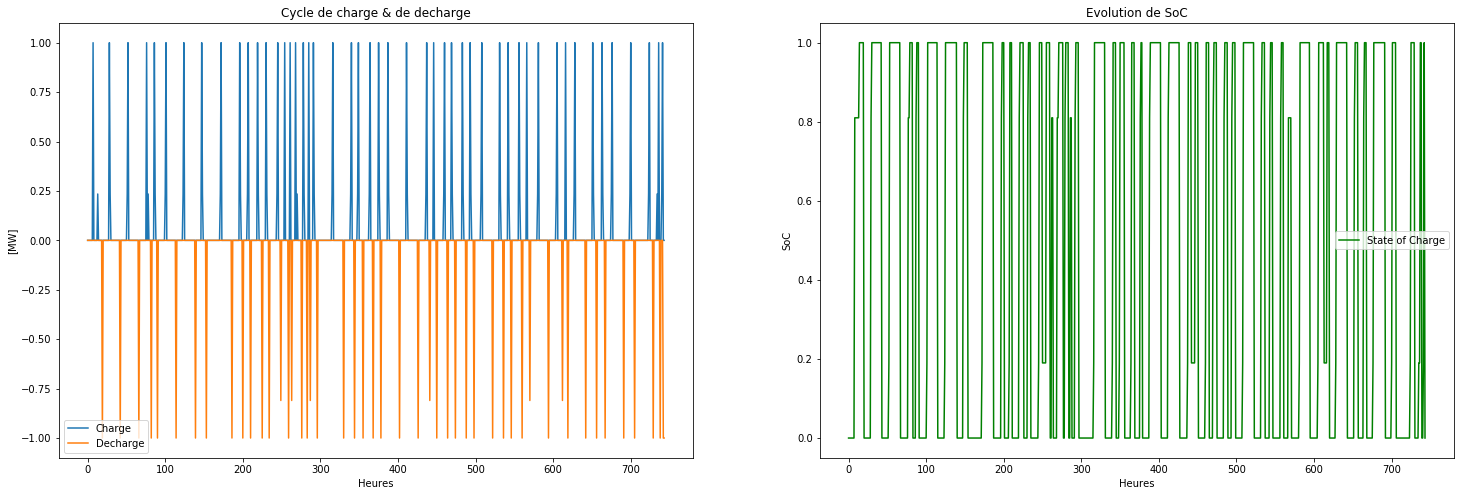

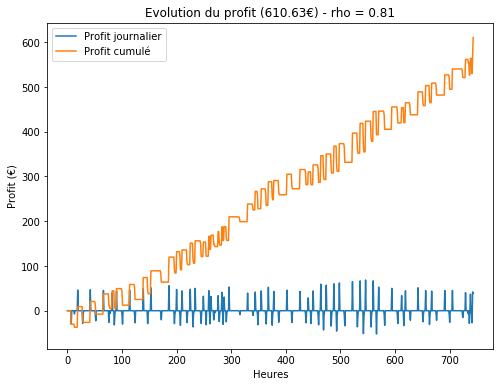

In [44]:
p81 =optim(price,rho=0.81,Pmax=1,Emax=1)

Solution - rho = 0.82 || Pmax =1 || Emax =1

Objectif =  632.2180487804877 



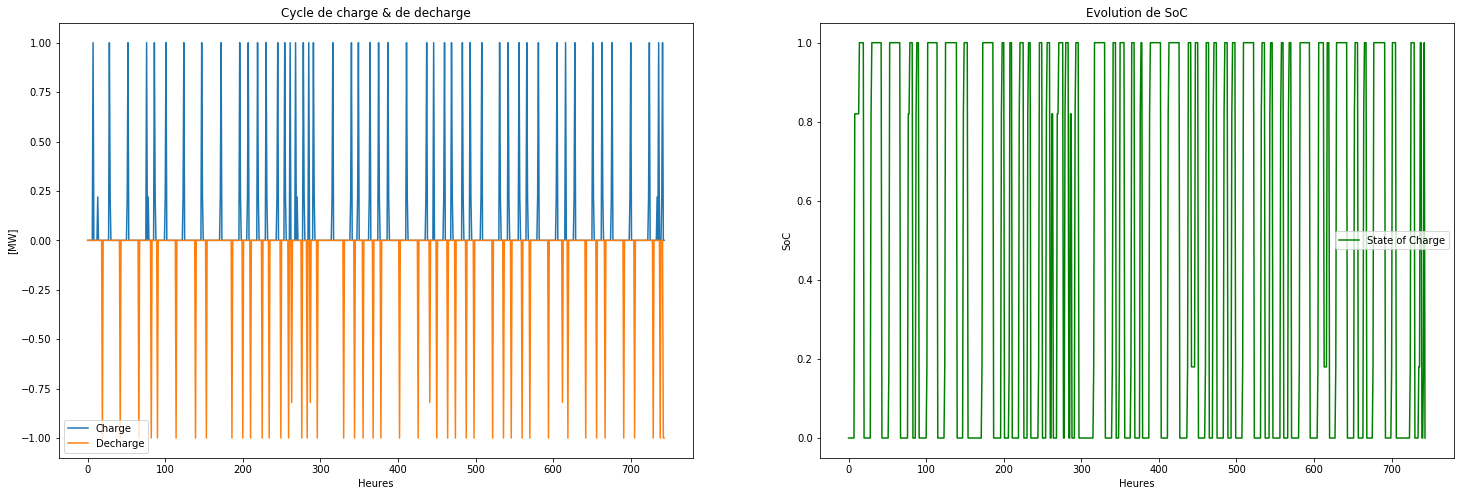

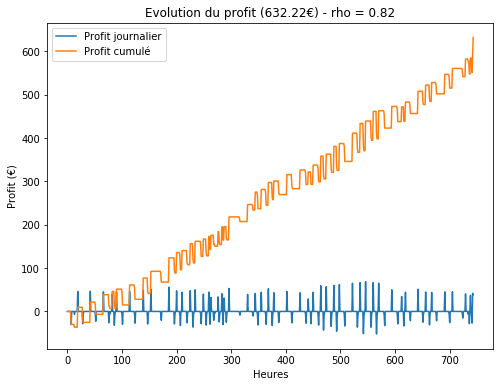

In [45]:
p82 =optim(price,rho=0.82,Pmax=1,Emax=1)

Solution - rho = 0.94 || Pmax =1 || Emax =1

Objectif =  912.9623319148935 



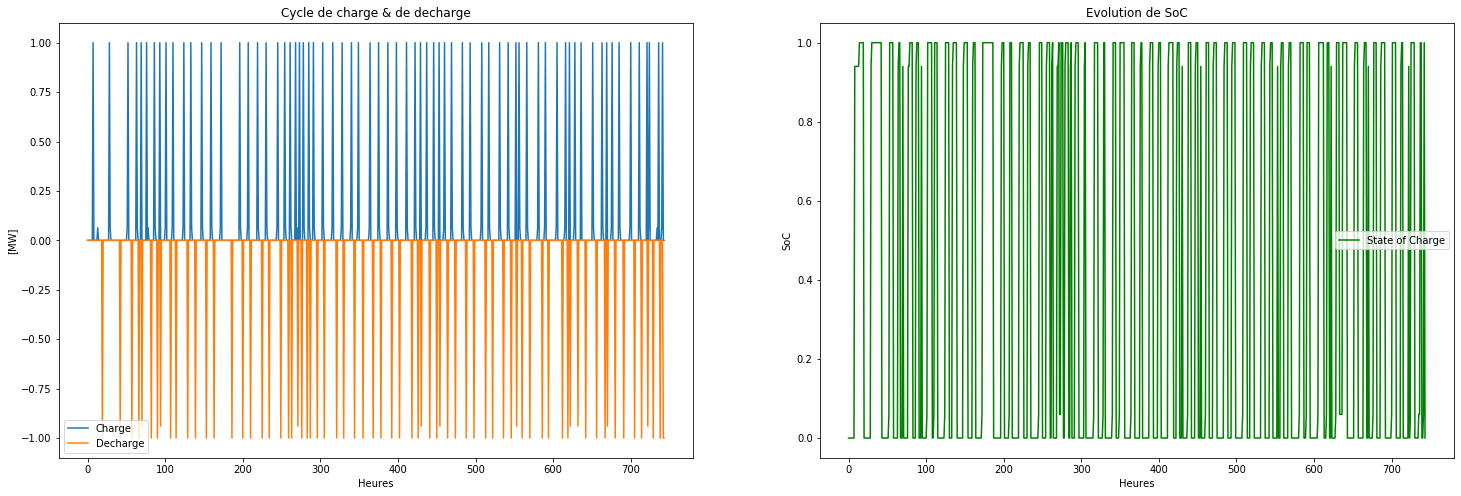

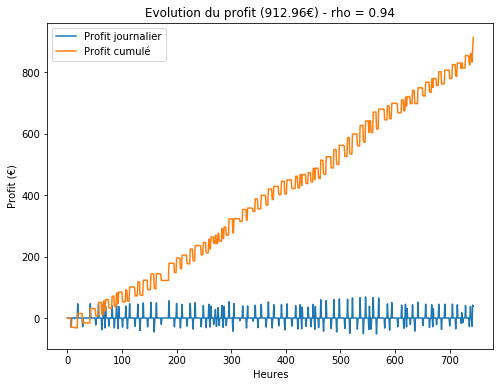

In [46]:
p94 =optim(price,rho=0.94,Pmax=1,Emax=1)

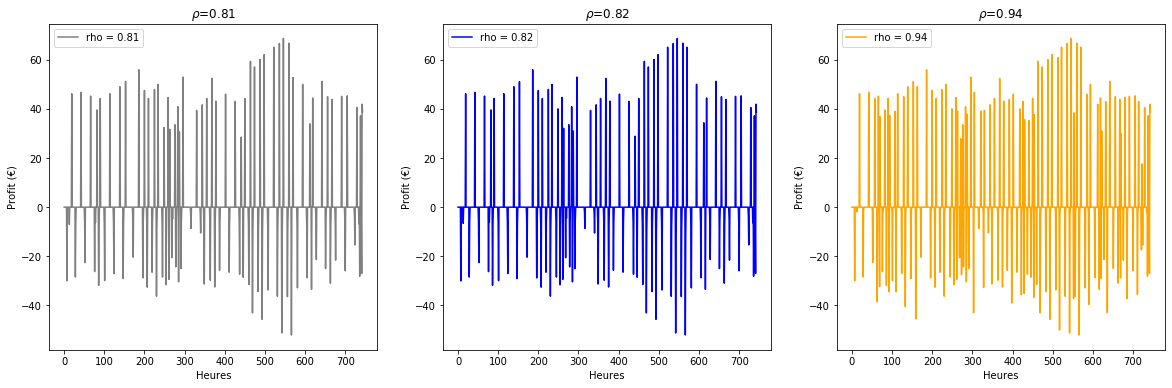

In [67]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.xlabel('Heures')
plt.ylabel('Profit (€)')
plt.title(r'$\rho$=0.81')
plt.plot(p81,label='rho = 0.81',c='gray')
plt.legend()
plt.subplot(132)
plt.xlabel('Heures')
plt.ylabel('Profit (€)')
plt.plot(p82,label='rho = 0.82',c='blue')
plt.legend()
plt.title(r'$\rho$=0.82')
plt.subplot(133)
plt.xlabel('Heures')
plt.ylabel('Profit (€)')
plt.plot(p94,label='rho = 0.94',c='orange')
plt.legend()
plt.title(r'$\rho$=0.94')
plt.show()

In [81]:
from IPython.display import display, Math

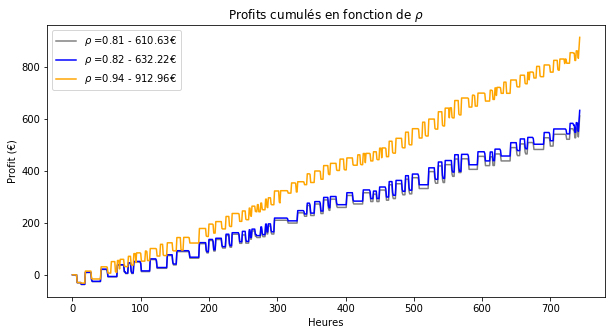

In [106]:
ps =[p81,p82,p94]
la = [0.81,0.82,0.94]
cs =['gray','blue','orange']
plt.figure(figsize=(10,5))
plt.xlabel('Heures')
plt.ylabel('Profit (€)')
for (i,p) in enumerate(ps):    
    plt.plot(np.cumsum(p),label=r'$\rho$ ='f'{la[i]} - {round(sum(p),2)}€',c=cs[i])
plt.legend()
plt.title(r'Profits cumulés en fonction de $\rho$')
plt.show()